<a href="https://colab.research.google.com/github/skreddypalvai/s3Ho4t5iMRItcowM/blob/main/CNN_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.src.utils.tf_utils import set_random_seed
#reproducebility
set_random_seed(42)

In [2]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Input, TimeDistributed, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Define constants
train_data_dir = '/content/drive/MyDrive/images/training'
test_data_dir = '/content/drive/MyDrive/images/testing'
sequence_length = 3
img_width, img_height = 128, 128
channels = 3

In [4]:
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype('float32') / 255.0  # Normalize pixel values
    return img

# 1. Data Preprocessing
def preprocess_data(data_dir):
    sequences = []
    labels = []

    for subdir in os.listdir(data_dir):
        subpath = os.path.join(data_dir, subdir)
        if os.path.isdir(subpath):
            images = sorted([f for f in os.listdir(subpath) if f.endswith('.jpg')])
            for i in range(0, len(images) - sequence_length + 1, sequence_length):
                sequence = []
                for j in range(i, i + sequence_length):
                    image_path = os.path.join(subpath, images[j])
                    img = load_and_preprocess_image(image_path)
                    sequence.append(img)
                sequences.append(sequence)

                # Labeling based on subfolder
                label = 1 if subdir == 'flip' else 0
                labels.append(label)
    return np.array(sequences), np.array(labels)

In [5]:
X_train, y_train = preprocess_data(train_data_dir)
X_test, y_test = preprocess_data(test_data_dir)

In [6]:
train_classes = np.unique(y_train)
test_classes = np.unique(y_test)
print("Classes in y_train:", train_classes)
print("Classes in y_test:", test_classes)

Classes in y_train: [0 1]
Classes in y_test: [0 1]


In [7]:
print(f'Training Sequences shape: {X_train.shape}')
print(f'Training Labels shape: {y_train.shape}')
print(f'Test Sequences shape: {X_test.shape}')
print(f'Test Labels shape: {y_test.shape}')

Training Sequences shape: (797, 3, 128, 128, 3)
Training Labels shape: (797,)
Test Sequences shape: (198, 3, 128, 128, 3)
Test Labels shape: (198,)


In [8]:
!rm -rf ./logs/

In [9]:
import tensorflow.keras.backend as K
K.clear_session()

In [10]:

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, channels)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten()
])
rnn_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, cnn_model.output_shape[-1])),
    LSTM(64)
])
model = Sequential([
    TimeDistributed(cnn_model, input_shape=(sequence_length, img_width, img_height, channels)),
    TimeDistributed(Flatten()),
    rnn_model,
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 3, 4608)           240832    
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 3, 4608)           0         
 stributed)                                                      
                                                                 
 sequential_1 (Sequential)   (None, 64)                1229312   
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1470209 (5.61 MB)
Trainable params: 1470209 (5.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Training the model
training = model.fit(X_train, y_train, epochs=14,validation_data=[X_test,y_test], batch_size=32)

Epoch 1/14
25/25 [==============================] - 55s 2s/step - loss: 0.6931 - accuracy: 0.5107 - val_loss: 0.6854 - val_accuracy: 0.5152
Epoch 2/14
25/25 [==============================] - 50s 2s/step - loss: 0.6694 - accuracy: 0.5872 - val_loss: 0.6636 - val_accuracy: 0.6162
Epoch 3/14
25/25 [==============================] - 52s 2s/step - loss: 0.5750 - accuracy: 0.6951 - val_loss: 0.4278 - val_accuracy: 0.8182
Epoch 4/14
25/25 [==============================] - 51s 2s/step - loss: 0.4138 - accuracy: 0.8256 - val_loss: 0.3696 - val_accuracy: 0.8030
Epoch 5/14
25/25 [==============================] - 51s 2s/step - loss: 0.2585 - accuracy: 0.8996 - val_loss: 0.1976 - val_accuracy: 0.9192
Epoch 6/14
25/25 [==============================] - 51s 2s/step - loss: 0.2122 - accuracy: 0.9235 - val_loss: 0.1030 - val_accuracy: 0.9697
Epoch 7/14
25/25 [==============================] - 56s 2s/step - loss: 0.1576 - accuracy: 0.9448 - val_loss: 0.0939 - val_accuracy: 0.9646
Epoch 8/14
25/25 [==

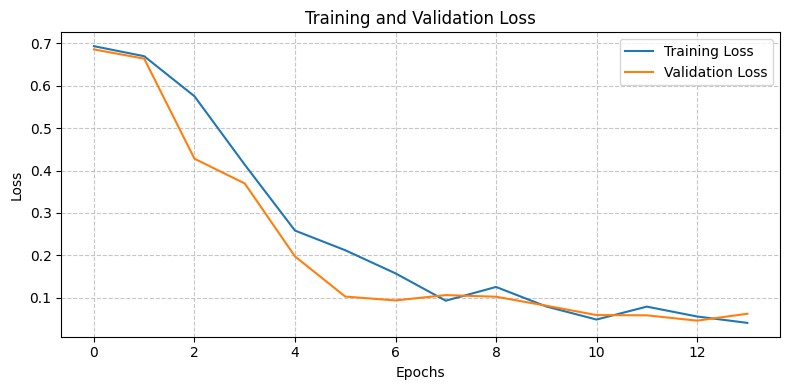

In [13]:
train_loss = training.history['loss']
val_loss = training.history['val_loss']
fig, ax1 = plt.subplots(figsize=(8, 4))
# Plot training and validation loss
ax1.plot(train_loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()
plt.tight_layout()
plt.show()

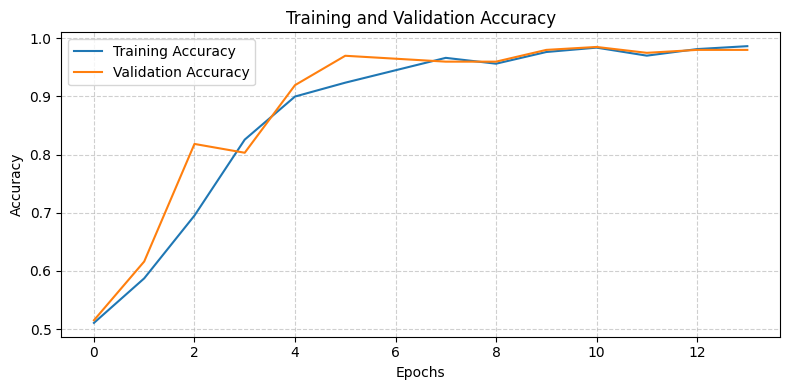

In [14]:
train_accuracy = training.history['accuracy']
val_accuracy = training.history['val_accuracy']
#monitoring train and val accuracy
fig, ax2 = plt.subplots(figsize=(8, 4))
ax2.plot(train_accuracy, label='Training Accuracy')
ax2.plot(val_accuracy, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()
plt.tight_layout()
plt.show()

In [15]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
report = classification_report(y_test, y_pred)
print(report)

7/7 [==============================] - 4s 455ms/step
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       102
           1       0.96      1.00      0.98        96

    accuracy                           0.98       198
   macro avg       0.98      0.98      0.98       198
weighted avg       0.98      0.98      0.98       198



In [21]:
cm = confusion_matrix(y_test, y_pred)

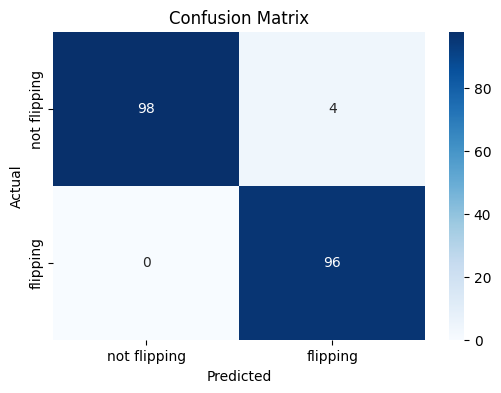

In [23]:
class_names = ['not flipping', 'flipping']
# Create a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 52ms/step


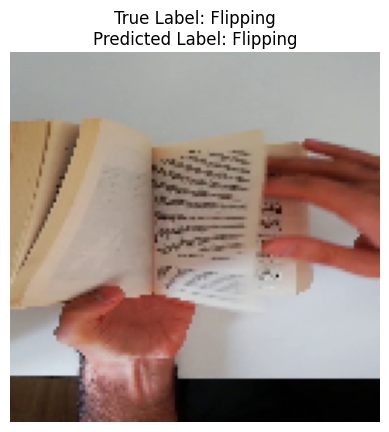

In [ ]:
random_index = random.randint(0, len(X_test) - 1)
random_image = X_test[random_index]
true_label = y_test[random_index]
random_image = random_image.reshape(1, sequence_length, img_width, img_height, channels)
predicted_label = model.predict(random_image)
predicted_label = (predicted_label > 0.5).astype(int)
plt.imshow(random_image[0][0])
plt.title(f"True Label: {'Flipping' if true_label == 1 else 'Not Flipping'}\nPredicted Label: {'Flipping' if predicted_label == 1 else 'Not Flipping'}")
plt.axis('off')
plt.show()